6.661338147750939e-16
Euler–Cromer order n = -3.232e-05 ± 1.042e-05, (R² = 0.6579)
RK4 order n = 2.196 ± 0.5326


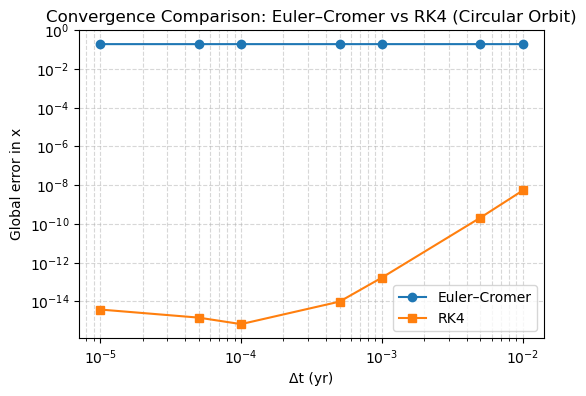

In [38]:
import numpy as np
import math
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy import stats



#this defintion is the same as the one in Kasturi's C1, C2, C3 and C5 code
def euler_circular_error(G=4*math.pi**2, dt=1e-4, fraction=0.1):
    """
    Simulate circular orbit (a=1, e=0 -> T=1 yr) for a fraction of orbit.
    Exact solution: x(t) = cos(2π * t / T), y(t) = sin(2π * t / T)
    """
    a = 1.0
    # Initial conditions for circular orbit: r = a, v = sqrt(GM/a)
    x, y = a, 0.0
    vx, vy = 0.0, math.sqrt(G / a)  # since M=1

    T = a**1.5
    total_time = fraction * T
    nsteps = int(total_time / dt)

    # Integrate (Euler–Cromer)
    for _ in range(nsteps):
        r = math.hypot(x, y)
        ax = -G * x / r**3
        ay = -G * y / r**3
        vx += ax * dt
        vy += ay * dt
        x += vx * dt
        y += vy * dt

    # Exact x at time = fraction * T
    theta_exact = 2 * math.pi * fraction
    x_exact = a * math.cos(theta_exact)
    error = abs(x - x_exact)
    return error




def rk4_circular_error(dt=1e-4, fraction=0.1):
    """
    Simulating the RK4 (Runge Kutta 4) Method 
    """
    a = 1.0
    G = 4*math.pi**2
    # Initial conditions for circular orbit
    x, y = a, 0.0
    vx, vy = 0.0, math.sqrt(G / a) #M=1 

    T = a**1.5
    total_time = fraction * T
    nsteps = int(total_time / dt)

    def acceleration(x, y): #differention of x twice
        r = math.hypot(x, y)
        ax = -G * x / r**3
        ay = -G * y / r**3
        return ax, ay

    for _ in range(nsteps): #RK4 method
        ax1, ay1 = acceleration(x, y) #k1 (like 1st time step)
        k1x, k1y = vx, vy #differential of x once
        k1vx, k1vy = ax1, ay1 #differential of x twice or vx/vy once

        ax2, ay2 = acceleration(x + k1x/2*dt, y + k1y/2*dt) #k2 (second step)
        k2x, k2y = vx + k1vx/2*dt, vy + k1vy/2*dt
        k2vx, k2vy = ax2, ay2

        ax3, ay3 = acceleration(x + k2x/2*dt, y +  k2y/2*dt) #k3 (third step)
        k3x, k3y = vx + k2vx/2*dt, vy + k2vy/2*dt
        k3vx, k3vy = ax3, ay3

        ax4, ay4 = acceleration(x + k3x*dt, y + k3y*dt) #k4 (4th step)
        k4x, k4y = vx + k3vx*dt, vy + k3vy*dt
        k4vx, k4vy = ax4, ay4

        x = x + (dt/6.0) * (k1x + 2*k2x + 2*k3x + k4x) 
        y = y+ (dt/6.0) * (k1y + 2*k2y + 2*k3y + k4y)
        vx = vx+ (dt/6.0) * (k1vx + 2*k2vx + 2*k3vx + k4vx)
        vy = vy + (dt/6.0) * (k1vy + 2*k2vy + 2*k3vy + k4vy)

    # Exact x at time = fraction * T
    theta_exact = 2 * math.pi * fraction
    x_exact = a * math.cos(theta_exact)
    error = abs(x - x_exact)
    return error

#print(rk4_circular_error(dt=1e-4, fraction=0.1)) #this is just a test


dts = np.array([1e-2, 5e-3, 1e-3, 5e-4, 1e-4, 5e-5, 1e-5])
errors = np.array([euler_circular_error(dt) for dt in dts])
errors_rk4 = np.array([rk4_circular_error(dt) for dt in dts])

def fitconvergence(dts, errors): #made fit for covergence to use on both RK4 and Euler-Cromer
    log_dt = np.log10(dts)
    log_err = np.log10(errors)
    slope, intercept, r_value, _, std_err = stats.linregress(log_dt, log_err) 
    C_fit = 10**intercept
    return slope, C_fit, r_value, std_err

nfit_eu, cintercept_eu, corr_eu, std_eu = fitconvergence(dts, errors)
nfit_rk4, cintercept_rk4, corr_rk4, std_rk4 = fitconvergence(dts, errors_rk4)

print(f"Euler–Cromer order n = {nfit_eu:.4g} ± {std_eu:.4g}, (R² = {corr_eu**2:.4f})")
print(f"RK4 order n = {nfit_rk4:.4g} ± {std_rk4:.4g}")

# Plot(basically the same as the C3)
plt.figure(figsize=(6,4))
plt.loglog(dts, errors, "o-", label="Euler–Cromer") 
plt.loglog(dts, errors_rk4, "s-", label="RK4")
plt.xlabel("Δt (yr)")
plt.ylabel("Global error in x")
plt.title("Convergence Comparison: Euler–Cromer vs RK4 (Circular Orbit)")
plt.legend(); plt.grid(True, which="both", ls="--", alpha=0.5)
plt.show()
